In [1]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

UsageError: Line magic function `%tensorflow_version` not found.


In [20]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [22]:
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [23]:
hist.head(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2020-04-07,10550.00,9954.40,10397.20,100.45,1032566.57,10106.10
2020-04-08,10626.54,9541.47,10032.79,5334.00,54946325.82,10301.15
2020-04-09,10375.40,10050.00,10347.90,56.20,575285.83,10230.60
2020-04-10,10280.70,9522.40,10230.60,64.04,627563.31,9709.30
2020-04-11,9793.66,9358.38,9602.61,3264.99,31401771.76,9617.72


In [24]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [25]:
train, test = train_test_split(hist, test_size=0.2)

In [26]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

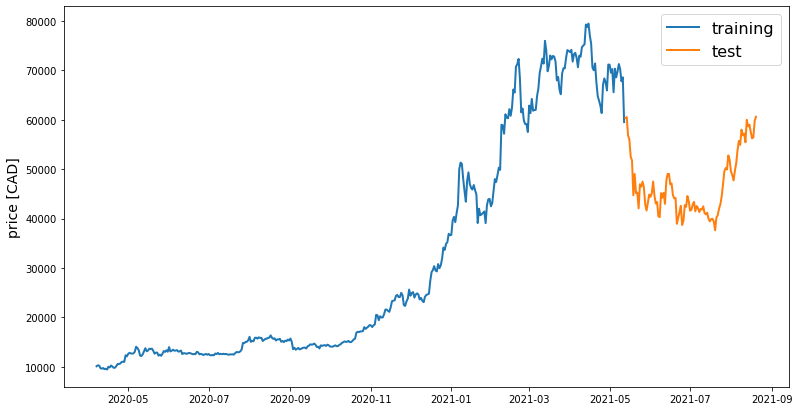

In [27]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [28]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [29]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [30]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [31]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [32]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [33]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [50]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 4s 74ms/step - loss: 0.0163 - val_loss: 0.0110
Epoch 2/20
13/13 [==============================] - 0s 16ms/step - loss: 0.0074 - val_loss: 0.0055
Epoch 3/20
13/13 [==============================] - 0s 14ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 4/20
13/13 [==============================] - 0s 14ms/step - loss: 0.0077 - val_loss: 0.0035
Epoch 5/20
13/13 [==============================] - 0s 15ms/step - loss: 0.0047 - val_loss: 0.0034
Epoch 6/20
13/13 [==============================] - 0s 16ms/step - loss: 0.0050 - val_loss: 0.0034
Epoch 7/20
13/13 [==============================] - 0s 15ms/step - loss: 0.0041 - val_loss: 0.0031
Epoch 8/20
13/13 [==============================] - 0s 14ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 9/20
13/13 [==============================] - 0s 14ms/step - loss: 0.0042 - val_loss: 0.0031
Epoch 10/20
13/13 [==============================] - 0s 14ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 11/

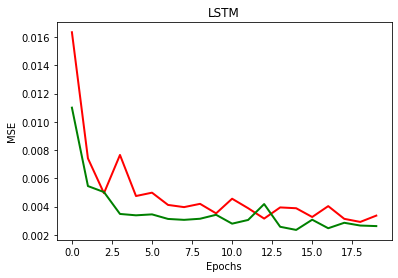

In [51]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [43]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.04291896664751478

In [47]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE


0.0030774299401816274

In [48]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.6552325599972303

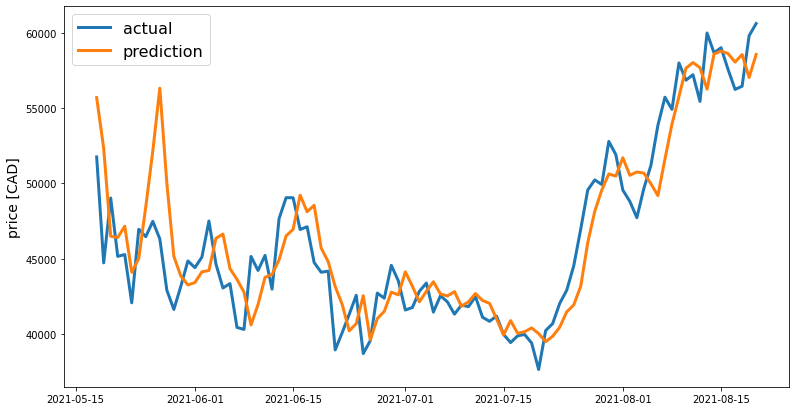

In [36]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)